# Stock Price Prediction using Recurrent Neural Networks (RNN)

In this notebook, we'll build an RNN model to predict Microsoft stock prices using historical data. We'll use LSTM (Long Short-Term Memory) networks, which are a type of RNN that can learn long-term dependencies in time series data.

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os
import glob
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load and Explore the Data

In [2]:
# Get list of all CSV files in the dataset folder
csv_files = glob.glob('dataset/*.csv')
print(f"Found {len(csv_files)} CSV files: {csv_files}")

# Use the most recent file (by filename date)
csv_files.sort()  # Sort files alphabetically
latest_file = csv_files[-1]  # Take the last file (most recent)
print(f"Using the most recent file: {latest_file}")

# Load the data
df = pd.read_csv(latest_file)

# Display the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Found 3 CSV files: ['dataset/MSFT_1986-03-13_2025-05-12.csv', 'dataset/MSFT_1986-03-13_2025-04-06.csv', 'dataset/MSFT_1986-03-13_2025-04-17.csv']
Using the most recent file: dataset/MSFT_1986-03-13_2025-05-12.csv
Dataset shape: (9868, 7)


,date,open,high,low,close,adj_close,volume
0,NaN,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
1,1986-03-13,0.08854199945926666,0.1015629991889,0.08854199945926666,0.09722200036048889,0.05970701575279236,1031788800
2,1986-03-14,0.09722200036048889,0.10243099927902222,0.09722200036048889,0.10069400072097778,0.06183929368853569,308160000
3,1986-03-17,0.10069400072097778,0.10329899936914444,0.10069400072097778,0.10243099927902222,0.06290601193904877,133171200
4,1986-03-18,0.10243099927902222,0.10329899936914444,0.09895800054073334,0.09982600063085556,0.06130620092153549,67766400


In [4]:
# First, drop the row with 'MSFT' values
df = df[df['date'] != 'MSFT']
# Also drop any row with NaN in the date column
df = df.dropna(subset=['date'])

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Convert all price columns to float
numeric_columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
df[numeric_columns] = df[numeric_columns].astype(float)

# Set date as index
df = df.set_index('date')

# Display the cleaned data
df.head()

,open,high,low,close,adj_close,volume
date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.059707,1.031789e+09
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.061839,3.081600e+08
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.062906,1.331712e+08
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061306,6.776640e+07
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060240,4.789440e+07


In [5]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# If there are any missing values, fill them (forward fill)
if df.isnull().sum().sum() > 0:
    df = df.fillna(method='ffill')
    print("\nMissing values after filling:")
    print(df.isnull().sum())

Missing values in each column:
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64


## 3. Visualize the Stock Price Data

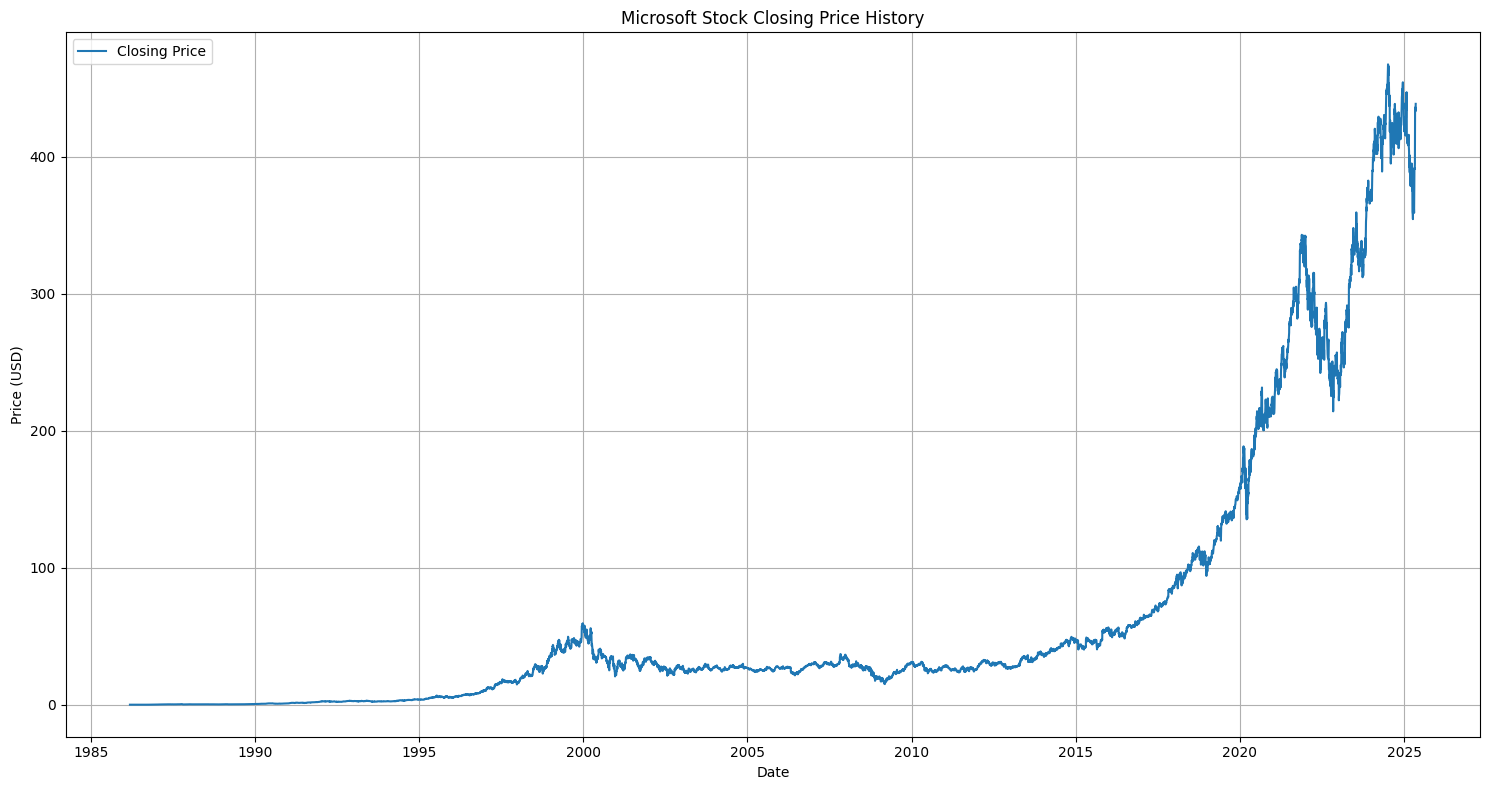

In [6]:
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['close'], label='Closing Price')
plt.title('Microsoft Stock Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Plot more recent data (last 500 trading days)
recent_data = df[-500:]

plt.figure(figsize=(15, 8))
plt.plot(recent_data.index, recent_data['close'], label='Closing Price')
plt.title('Microsoft Recent Stock Closing Price (Last 500 Trading Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Feature Selection and Data Preparation

In [ ]:
# Select features for our model
# We'll use 'open', 'high', 'low', 'close', 'volume' as features
features = ['open', 'high', 'low', 'close', 'volume']
data = df[features].copy()

# Create some additional features that might be helpful
data['HL_PCT'] = (data['high'] - data['low']) / data['close'] * 100.0  # High-Low percentage
data['PCT_change'] = (data['close'].pct_change()) * 100.0  # Percentage change in price

# Drop rows with NaN values that were created by pct_change()
data = data.dropna()

# Display the data with new features
data.head()

In [ ]:
# Normalize the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a separate scaler for the close price (to be used for inverse transformation later)
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit_transform(data[['close']])

print(f"Scaled data shape: {scaled_data.shape}")

## 5. Create Training and Testing Datasets

In [ ]:
# Define the function to create time series dataset
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        # X: features from i to i+time_steps
        X.append(dataset[i:(i + time_steps)])
        # y: close price at i+time_steps (3rd index is the 'close' price column)
        y.append(dataset[i + time_steps, 3])  # Index 3 is 'close' column in our scaled_data
    return np.array(X), np.array(y).reshape(-1, 1)

# Define the time steps (number of previous days to use for prediction)
time_steps = 60  # Using 60 days of data to predict the next day

# Create X (features) and y (target)
X, y = create_dataset(scaled_data, time_steps)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Testing set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

## 6. Build and Train the LSTM Model

In [ ]:
# Building the LSTM model
model = Sequential()

# Adding LSTM layers and Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
model.summary()

In [ ]:
# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # Reduced for faster execution, increase for better results
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

## 7. Evaluate Model Performance

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Make predictions on the test data
predicted = model.predict(X_test)

# Prepare to inverse transform the predictions and actual values
# We need to create arrays in the same format as our original input data (with all features)
# But we'll only fill in the close price column (index 3) with our predictions
test_data_dummy = np.zeros((len(y_test), scaled_data.shape[1]))
pred_data_dummy = np.zeros((len(predicted), scaled_data.shape[1]))

# Place the actual and predicted close values in the dummy arrays at the close price index (3)
test_data_dummy[:, 3] = y_test.flatten()  # Actual values
pred_data_dummy[:, 3] = predicted.flatten()  # Predicted values

# Inverse transform to get prices in original scale
test_data_inverse = scaler.inverse_transform(test_data_dummy)
pred_data_inverse = scaler.inverse_transform(pred_data_dummy)

# Extract the close price column
actual_prices = test_data_inverse[:, 3]
predicted_prices = pred_data_inverse[:, 3]

# Calculate performance metrics
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

In [ ]:
# Visualize the predictions vs actual values
plt.figure(figsize=(16, 8))
plt.plot(actual_prices, 'b', label='Actual Price')
plt.plot(predicted_prices, 'r', label='Predicted Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Trading Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plot a zoomed-in version of the last 100 days for clearer visualization
plt.figure(figsize=(16, 8))
plt.plot(actual_prices[-100:], 'b', label='Actual Price')
plt.plot(predicted_prices[-100:], 'r', label='Predicted Price')
plt.title('Microsoft Stock Price Prediction (Last 100 Test Days)')
plt.xlabel('Trading Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 8. Make Future Predictions

In [ ]:
# Predict future stock prices (next 30 days)
def predict_future(model, last_sequence, scaler, n_days=30, feature_count=7):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_days):
        # Get prediction for next day
        current_pred = model.predict(current_sequence.reshape(1, time_steps, feature_count))
        
        # Create a dummy array for inverse transform
        dummy_array = np.zeros((1, feature_count))
        dummy_array[0, 3] = current_pred[0, 0]  # 3 is the 'close' column index
        
        # Inverse transform to get the actual price
        pred_price = scaler.inverse_transform(dummy_array)[0, 3]
        future_predictions.append(pred_price)
        
        # Update sequence for next prediction
        # Remove the first day and add the new prediction at the end
        new_pred_point = dummy_array.copy()
        # For simplicity, we're using the same value for all features (not ideal but works for demonstration)
        new_pred_point[0, 0] = current_pred[0, 0]  # open
        new_pred_point[0, 1] = current_pred[0, 0] * 1.01  # high (slightly higher)
        new_pred_point[0, 2] = current_pred[0, 0] * 0.99  # low (slightly lower)
        # 3 is already filled with close
        new_pred_point[0, 4] = current_sequence[0, -1, 4]  # volume (use last known volume)
        new_pred_point[0, 5] = 0.01  # HL_PCT (placeholder)
        new_pred_point[0, 6] = 0.0  # PCT_change (placeholder)
        
        new_pred_scaled = scaler.transform(new_pred_point)
        current_sequence = np.append(current_sequence[:, 1:, :], 
                                  [new_pred_scaled], 
                                  axis=1)
    
    return future_predictions

# Get the last sequence from our test data
last_sequence = X_test[-1:]

# Predict the next 30 days
future_days = 30
future_predictions = predict_future(model, last_sequence[0], scaler, n_days=future_days, feature_count=len(data.columns))

# Get the last date in the dataset to start future predictions from
last_date = df.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='B')

# Plot the historical data along with future predictions
plt.figure(figsize=(16, 8))
plt.plot(df.index[-100:], df['close'].values[-100:], 'b', label='Historical Data')
plt.plot(prediction_dates, future_predictions, 'r--', label='Future Predictions')
plt.title('Microsoft Stock Price Forecast (Next 30 Trading Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the predicted future prices
future_df = pd.DataFrame({
    'Date': prediction_dates,
    'Predicted Close Price': future_predictions
})
future_df.set_index('Date', inplace=True)
future_df

## 9. Conclusion

In this notebook, we have:

1. Loaded and preprocessed Microsoft stock price data
2. Built an LSTM-based RNN model for time series prediction
3. Trained and evaluated the model's performance
4. Made future stock price predictions

The model shows reasonable predictions on the test data, but it's important to note that stock price prediction is inherently difficult due to market volatility and external factors. This model serves as a demonstration of how LSTMs can be applied to time series forecasting, but real investment decisions should incorporate many other factors and analyses.

## 10. Further Improvements

Several improvements could be made to enhance this model:

1. Incorporate more features like technical indicators (MACD, RSI, Bollinger Bands)
2. Include external data sources (market sentiment, news articles, economic indicators)
3. Try different architectures (bidirectional LSTM, GRU, Transformer models)
4. Implement hyperparameter tuning
5. Use more sophisticated train/validation/test split strategies for time series data